# iFood CRM Data Analyst Case

### Description

The objective of the team is to build a predictive model that will produce the highest profit for the
next direct marketing campaign, scheduled for the next month. 
The new campaign, sixth, aims at
selling a new gadget to the Customer Database. 
To build the model, a pilot campaign involving **2.240 customers** was carried out. 
The customers were selected at random and contacted by phone regarding the acquisition of the gadget. 
During the following months, customers who bought the offer were properly labeled. 
The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. 
Globally the campaign had a profit of -3.046MU. 
The success rate of the campaign was 15%. 

The objective is of the team is to develop a model that predicts customer behavior and to apply it to the rest of the customer base.
Hopefully the model will allow the company to cherry pick the customers that are most likely to
purchase the offer while leaving out the non-respondents, making the next campaign highly
profitable. Moreover, other than maximizing the profit of the campaign, the CMO is interested in
understanding to study the characteristic features of those customers who are willing to buy the
gadget.

### Key Objectives are:

1. Explore the data – don’t just plot means and counts. Provide insights, define cause and
effect. Provide a better understanding of the characteristic features of respondents;
2. Propose and describe a customer segmentation based on customers behaviors;
3. Create a predictive model which allows the company to maximize the profit of the next
marketing campaign.
4. Whatever else you think is necessary.

### Deliverables:

1. Data Exploration;
2. Segmentation;
3. Classification Model;
4. A short business presentation.

### Data Dictionary and Notes

At the botton of the notebook

---

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import scipy.stats as ss
from scipy.stats import chi2_contingency

In [32]:
# Load the main dataset
raw_ifood_df = pd.read_csv('ml_project1_data.csv')
raw_ifood_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## Customer Profile Analysis

These are the columns related to Customer Profile Information 

| categorical 	     | numerical 	            |
|-----------	     |-----------	            |
|Education - ordinal | Income  - continuous  	|
|Marital - nominal   | Kidhome  - discrete 	    |
|                    | Teenhome - discrete 	    |
|      	             | dtCustomer - interval    |
|                    | yearbirth - interval     |



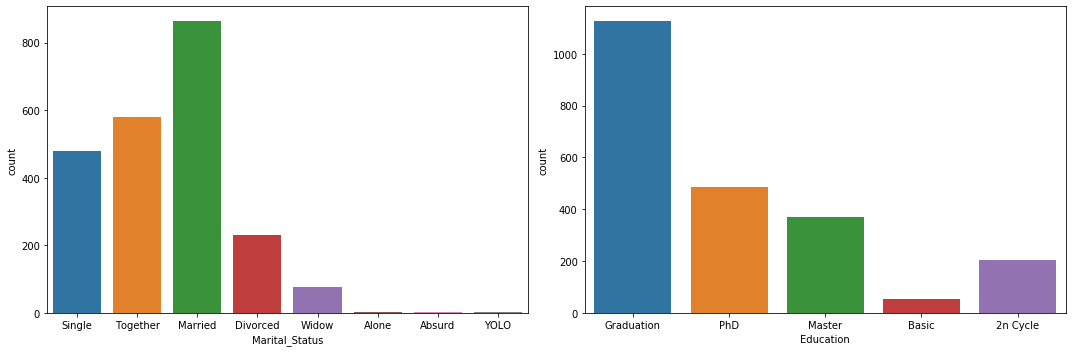

In [33]:
# Taking a look at the categorical variables
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(raw_ifood_df['Marital_Status'], ax=ax[0])
sns.countplot(raw_ifood_df['Education'], ax=ax[1])
plt.tight_layout()
fig.show()


### Some transformations are required:

* yearbirth -> customer_age: in years
* dtCustomer -> customer_days: customer's erollment in days 
* Education -> Education: as an ordered list \[Basic: 0, Graduation: 1, 2n Cycle: 2, Master: 3, PhD: 4\]

* Marital -> multiples using Dummy Variables
   - Married: boolean
   - Together: boolean
   - Single: boolean
   - Divorced: boolean
   - Widow: boolean
   - Alone: boolean
   - Absurd: boolean
   - YOLO : boolean    


In [74]:
# Create Customer Age Column
raw_ifood_df['Age'] = date.today().year - raw_ifood_df['Year_Birth']

# Number of days as a customer
raw_ifood_df['Customer_Days'] = (pd.to_datetime("now") - pd.to_datetime(raw_ifood_df['Dt_Customer'])) // np.timedelta64(1,'D')  

# Marital -> multiples using Dummy Variables
dummy_var_aux = pd.get_dummies(raw_ifood_df['Marital_Status'], prefix='marital')
ifood_df = pd.concat([raw_ifood_df,dummy_var_aux],axis=1)

# Replace Educational to an ordinal number
ifood_df = ifood_df.replace({'Education': {"Basic": 0,"Graduation": 1, "2n Cycle": 2, "Master": 3, "PhD": 4}})

# Look of the new dataset
customer_ifood_df = ifood_df[['Education', 'Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome'] + dummy_var_aux.columns.to_list() ]
customer_ifood_df.head()

,Education,Age,Customer_Days,Income,Kidhome,Teenhome,marital_Absurd,marital_Alone,marital_Divorced,marital_Married,marital_Single,marital_Together,marital_Widow,marital_YOLO
0,1,63,2821,58138.0,0,0,0,0,0,0,1,0,0,0
1,1,66,2271,46344.0,1,1,0,0,0,0,1,0,0,0
2,1,55,2470,71613.0,0,0,0,0,0,0,0,1,0,0
3,1,36,2297,26646.0,1,0,0,0,0,0,0,1,0,0
4,4,39,2319,58293.0,1,0,0,0,0,1,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f7ee5f310>,
      dtype=object)

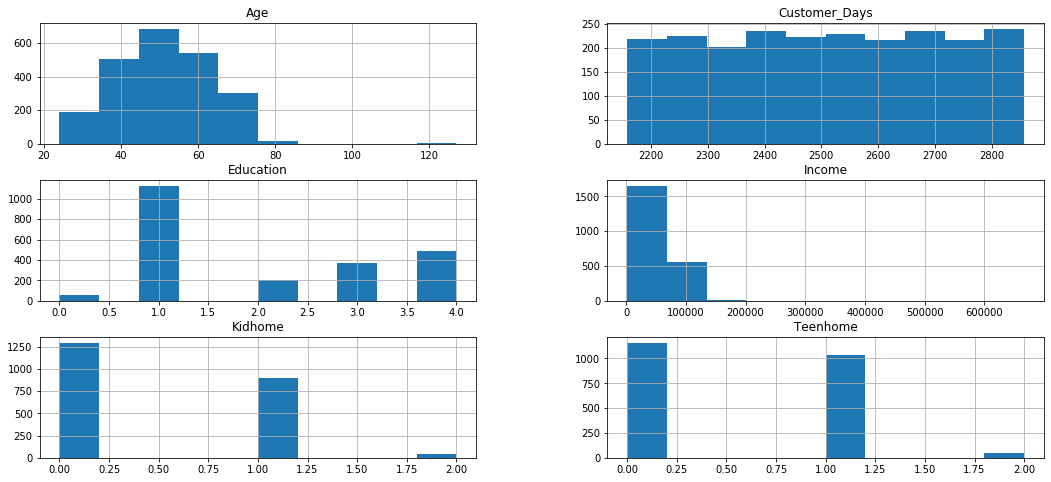

In [85]:
customer_ifood_df.hist( column = ['Education', 'Age', 'Customer_Days', 'Income', 'Kidhome', 'Teenhome'], figsize=(18,8))

In [90]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

### Outliers and missing data in Income columns

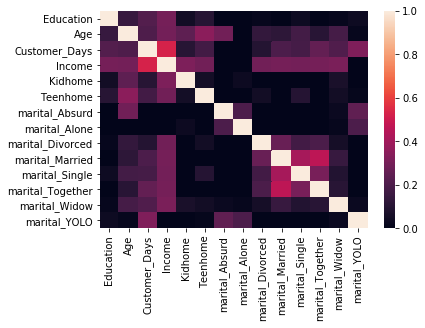

In [91]:
corr = customer_ifood_df.corr(method=cramers_v)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

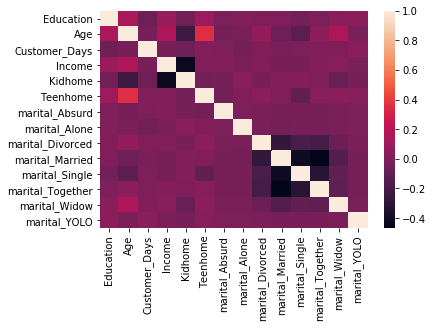

In [98]:
corr = customer_ifood_df.corr(method='pearson')

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

### Segmentation of Customers

In [4]:
(df.var())

ID                     1.054082e+07
Year_Birth             1.436179e+02
Income                 6.336838e+08
Kidhome                2.898725e-01
Teenhome               2.965219e-01
Recency                8.388237e+02
MntWines               1.132978e+05
MntFruits              1.581926e+03
MntMeatProducts        5.094743e+04
MntFishProducts        2.984325e+03
MntSweetProducts       1.704080e+03
MntGoldProds           2.721442e+03
NumDealsPurchases      3.733542e+00
NumWebPurchases        7.721252e+00
NumCatalogPurchases    8.544517e+00
NumStorePurchases      1.056873e+01
NumWebVisitsMonth      5.888606e+00
AcceptedCmp3           6.750283e-02
AcceptedCmp4           6.902615e-02
AcceptedCmp5           6.750283e-02
AcceptedCmp1           6.017993e-02
AcceptedCmp2           1.321939e-02
Complain               9.291257e-03
Z_CostContact          0.000000e+00
Z_Revenue              0.000000e+00
Response               1.269309e-01
dtype: float64

In [20]:
df.Education.value_counts()

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64

In [13]:
df.describe(include=[np.number])

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [16]:
df.ID

0        5524
1        2174
2        4141
3        6182
4        5324
        ...  
2235    10870
2236     4001
2237     7270
2238     8235
2239     9405
Name: ID, Length: 2240, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f74ce680510>,
      dtype=object)

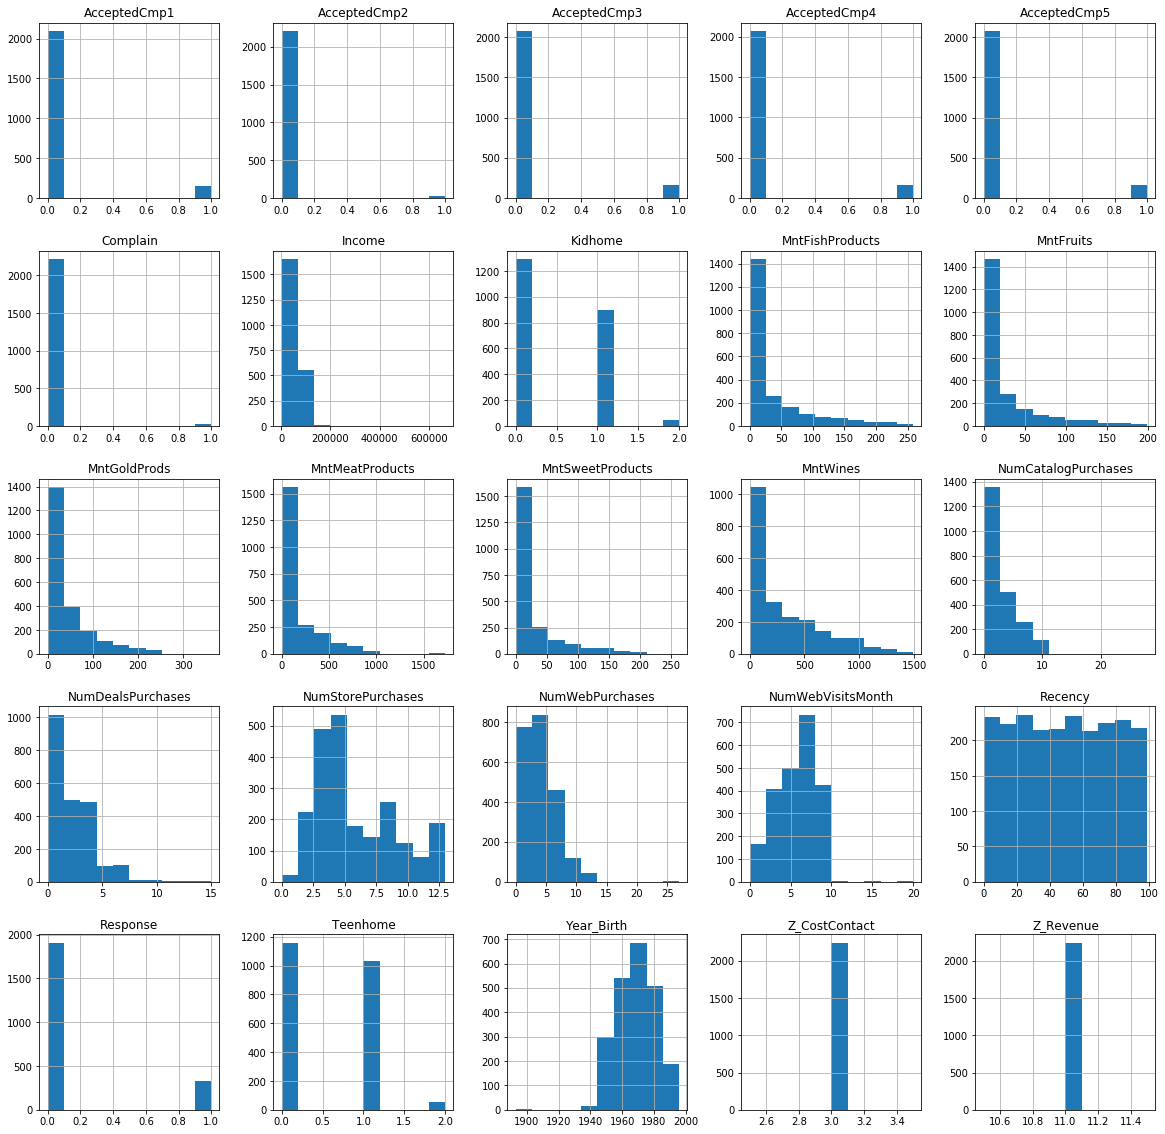

In [17]:
df.drop(['ID'], axis=1).hist(figsize=(20,20))

---
## Notes:

They sell products from 5 major categories: 
* wines
* rare meat products
* exotic fruits
* specially prepared fish
* sweet products

These can further be divided into: 
* gold
* regular products

3 sales channels: 
* physical stores
* catalogs
* website.

---
## Data dictionary
![alt text](dictionary.png "Title")